# Sequence restoration with Latent Diffusion Models

In [160]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

Let's also check what type of GPU we've got.

In [161]:
!nvidia-smi

Mon Dec 25 22:24:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P8    11W / 250W |   8179MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [162]:
import os
os.chdir("/home/alban/ImSeqCond/latent-diffusion/")

Load it.

In [163]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt=None):
    model = instantiate_from_config(config.model)
    
    if ckpt is not None:
        print(f"Loading model from {ckpt}")
        pl_sd = torch.load(ckpt)#, map_location="cpu")
        sd = pl_sd["state_dict"]
        m, u = model.load_state_dict(sd, strict=False)
    else:
        print("Instantiated model from config")
        
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("/home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T15-15-42_config_siar_recon/configs/2023-12-21T15-15-42-project.yaml")
    model = load_model_from_config(config, "/home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T15-15-42_config_siar_recon/checkpoints/epoch=000088.ckpt")
    return model

In [164]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

# count model parameters
params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"Model has {params/1e6:.2f}M parameters")

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Loading model from /home/alban/ImSeqCond/latent-diffusion/logs_saved/2023-12-21T15-15-42_config_siar_recon/checkpoints/epoch=000088.ckpt
Model has 114.54M parameters


In [165]:
# Load some custom data
from ldm.data.siar import SIAR

dataset = SIAR("/home/alban/ImSeqCond/data/SIARmini", set_type='val', resolution=256, max_sequence_size=4, downscale_f=4)

Wrong images excluded


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

/home/alban/ImSeqCond/.venv_ldm/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


rendering 6 examples of images '9' in 200 steps and using s=1.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler:   5%|▌         | 10/200 [00:00<00:09, 19.60it/s]

DDIM Sampler: 100%|██████████| 200/200 [00:10<00:00, 19.48it/s]


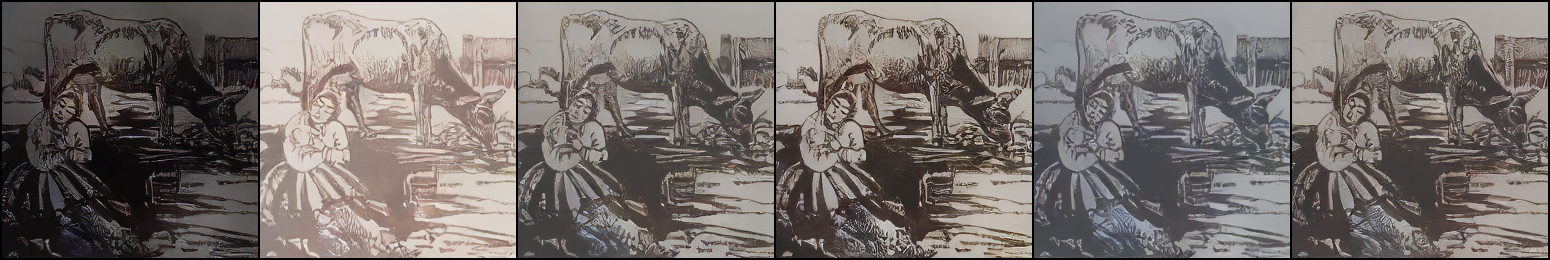

In [166]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

i = 9

images_indexes = [i]
n_samples_per_image = 6

ddim_steps = 200
ddim_eta = 0.0
scale = 1   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        """ uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.zeros(n_samples_per_image, 3, 64, 64).cuda().to(model.device)}
            ) """
        uc = model.get_learned_conditioning(
            torch.zeros(n_samples_per_image, 3, 4, 64, 64).cuda().to(model.device)
            )

        for image_index in images_indexes:
            print(f"rendering {n_samples_per_image} examples of images '{image_index}' in {ddim_steps} steps and using s={scale:.2f}.")
            

            xc = rearrange(torch.tensor(dataset[image_index]['label']), 's h w c -> c s h w').unsqueeze(0).repeat(n_samples_per_image, 1, 1, 1, 1)
            c = model.get_learned_conditioning(xc.to(model.device))

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_image,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_image)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [167]:
def plot_image(data, predict=None):
    """ For a single data point, plot the ground truth image, the input images and the predicted image
    Args:
        gt (torch.tensor): ground truth image
        input (torch.tensor): input images
        predict (torch.tensor): predicted image
    """
    gt, input = data['data'], data['label']
    
    label_images = data['label'].shape[0]
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 10))

    axes[0, 0].imshow(gt)
    axes[0, 0].set_title("Ground truth")
    
    for i in range(label_images):
        axes[i//5, i%5 + 1].imshow(input[i])
        axes[i//5, i%5 + 1].set_title("Input " + str(i+1))
        
    if predict is not None:
        axes[1, 0].imshow(predict)
        axes[1, 0].set_title("Predicted")
        
    plt.show()

In [168]:
def prepare_for_plot(data, all_samples=None):
    
    data_prepared = dict()
    for key, value in data.items():
        if key in ['data', 'label']:
            data_prepared[key] = (value + 1) / 2
    
    predict_prepared = rearrange(all_samples[0][0], 'c h w -> h w c')
    #predict_prepared = (predict_prepared + 1) / 2
    predict_prepared = predict_prepared.cpu().detach().numpy()
    
    return data_prepared, predict_prepared

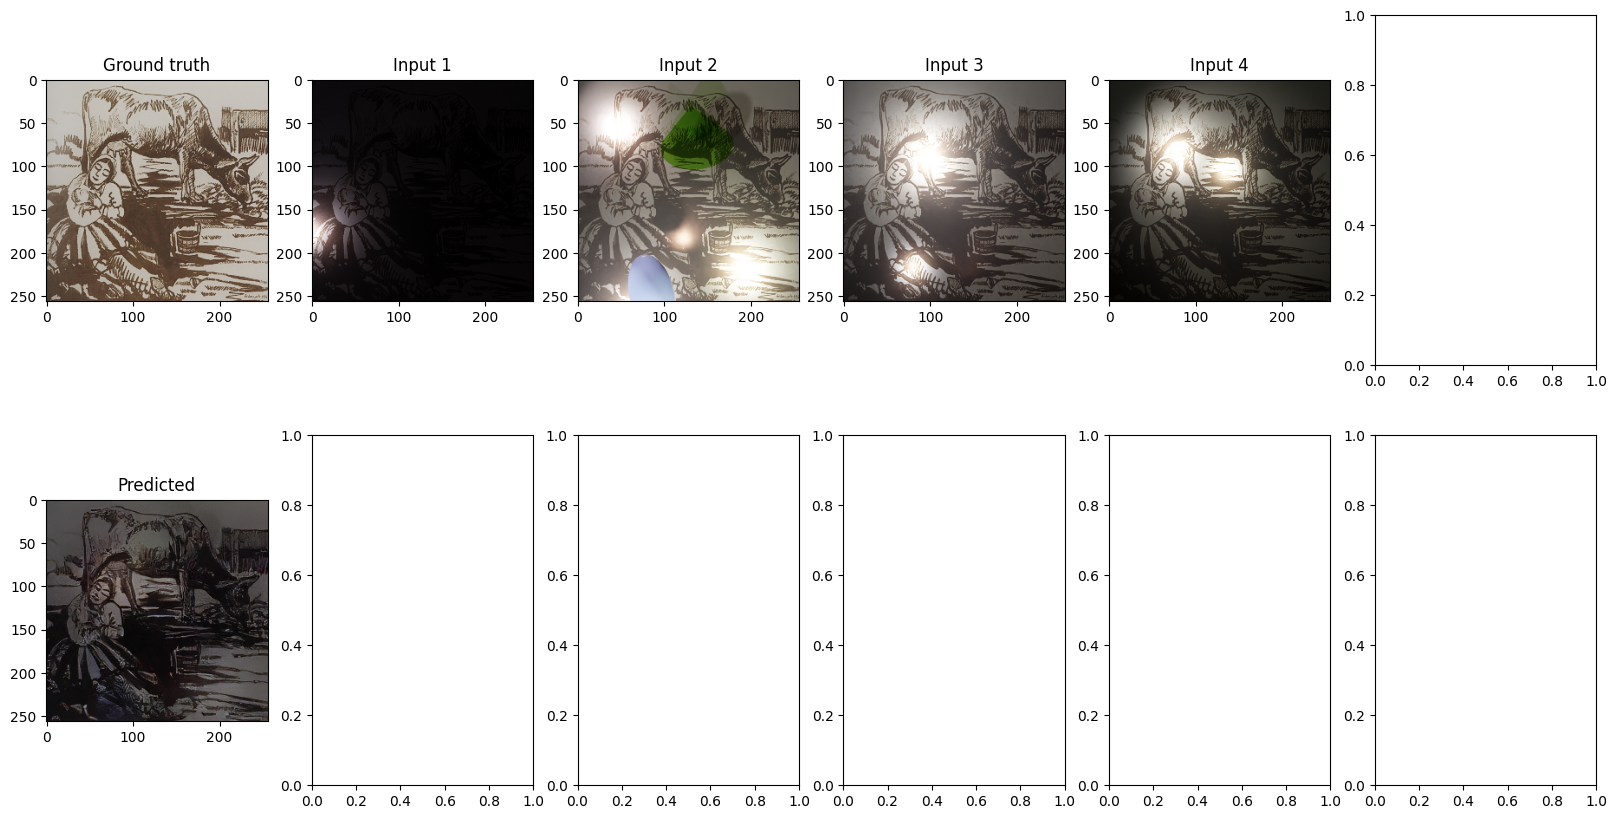

In [169]:
plot_image(*prepare_for_plot(dataset[i], all_samples))

Text(0.5, 1.0, 'Cond in pixel space')

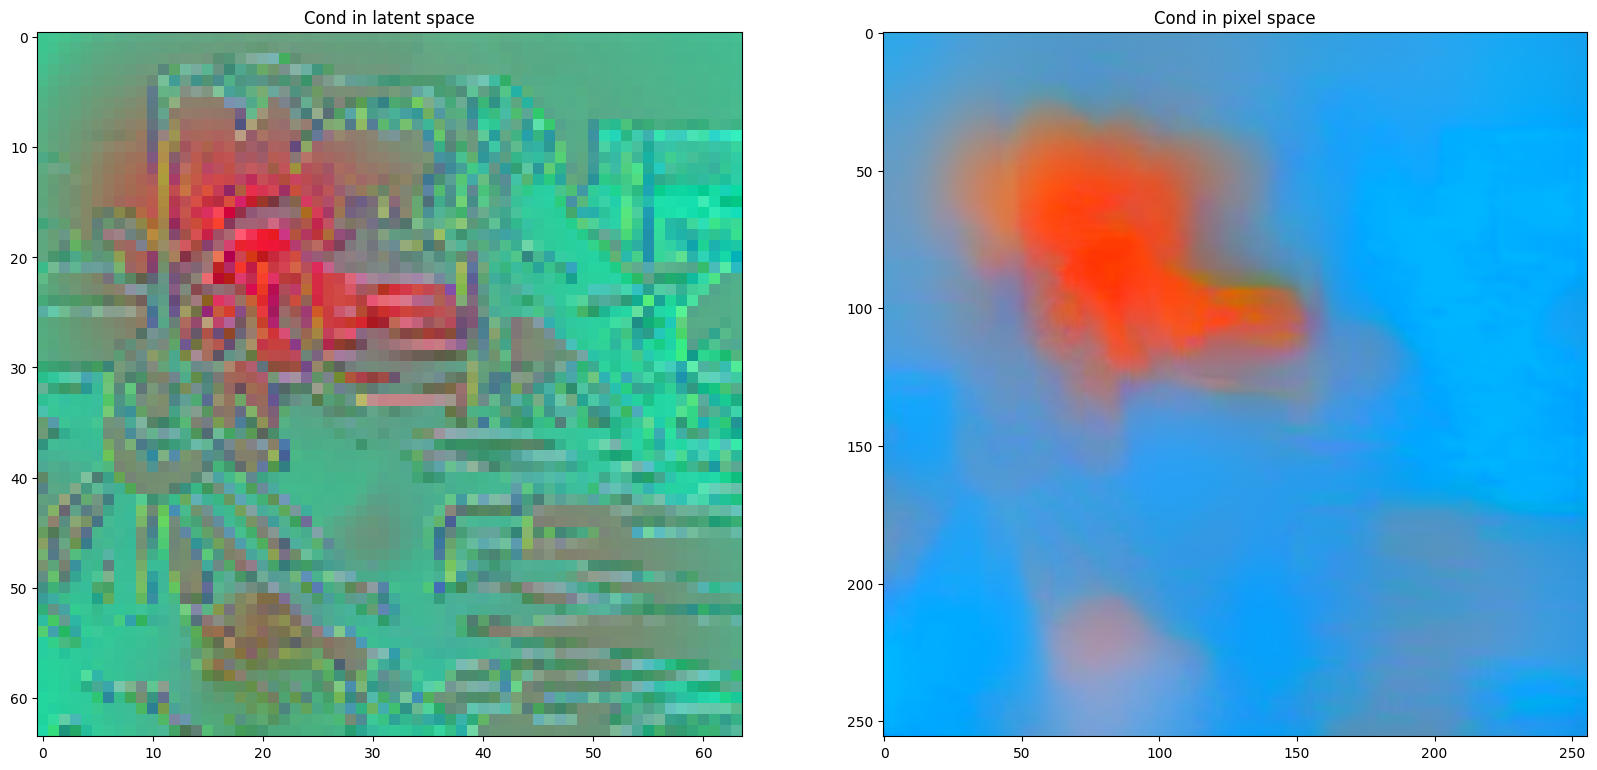

In [170]:
cond = c[0]

# convert cond in 0, 1
cond = (cond - cond.min()) / (cond.max() - cond.min())
cond = rearrange(cond, 'c h w -> h w c')
cond = cond.detach().cpu().numpy()

cond_decode = model.decode_first_stage(c[0].unsqueeze(0))

cond_decode = torch.clamp((cond_decode+1.0)/2.0,
                                         min=0.0, max=1.0)
cond_decode = rearrange(cond_decode.squeeze(), 'c h w -> h w c')
cond_decode = cond_decode.detach().cpu().numpy()


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(cond)
axes[0].set_title("Cond in latent space")

axes[1].imshow(cond_decode)
axes[1].set_title("Cond in pixel space")